In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

In [3]:
import s3fs 
import AFQ.data as afd
fs = s3fs.S3FileSystem()

/Users/arokem/miniconda3/envs/afq/lib/python3.8/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/arokem/miniconda3/envs/afq/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [4]:
import os.path as op

In [5]:
ll = fs.ls("hcp.dki/derivatives/dki1000_3000")

In [6]:
subjects = [ff.split('-')[1] for ff in ll]

In [7]:
len(subjects)

1064

In [8]:
subject = subjects[-1]

In [9]:
subject

'996782'

In [10]:
bucket = 'hcp.dki'

In [11]:
remote_dti1000_path =\
    "%s/derivatives/dti1000" % (bucket)

remote_dti1000_2000_path =\
    "%s/derivatives/dti1000_2000" % (bucket)

remote_dki1000_2000_path =\
    "%s/derivatives/dki1000_2000" % (bucket)

remote_dki2000_3000_path =\
    "%s/derivatives/dki2000_3000" % (bucket)

remote_dki1000_3000_path =\
    "%s/derivatives/dki1000_3000" % (bucket)


In [12]:
# !rm reliability_comparison_md.csv

In [13]:
reliability_table = "reliability_comparison_md.csv"

if not op.exists(reliability_table):
    mad_dti = []
    med_dti = []
    mad_dki = []
    med_dki = []

    for subject in subjects:
        print(subject)
        rpath = op.join(remote_dti1000_path, f'sub-{subject}', 'ses-01', 'dwi',
                                f'sub-{subject}_dwi_model-DTI_MD.nii.gz')

        img_md1000 = afd.s3fs_nifti_read(rpath)

        rpath = op.join(remote_dti1000_2000_path, f'sub-{subject}', 'ses-01', 'dwi',
                                f'sub-{subject}_dwi_model-DTI_MD.nii.gz')

        img_md1000_2000 = afd.s3fs_nifti_read(rpath)

        md1000 = img_md1000.get_fdata()

        md1000_2000 = img_md1000_2000.get_fdata()

        img_wm_mask =  afd.s3fs_nifti_read(f's3://hcp.dki/derivatives/wm_mask/sub-{subject}/ses-01/dwi/sub-{subject}_dwi_wm_mask.nii.gz')

        data_wm_mask = img_wm_mask.get_fdata().astype(bool)

        md1000_wm = md1000[data_wm_mask]
        md1000_2000_wm = md1000_2000[data_wm_mask]

        rpath = op.join(remote_dki1000_2000_path, f'sub-{subject}', 'ses-01', 'dwi',
                        f'sub-{subject}_dwi_model-DKI_MD.nii.gz')

        img_dki_md1000_2000 = afd.s3fs_nifti_read(rpath)

        rpath = op.join(remote_dki1000_3000_path, f'sub-{subject}', 'ses-01', 'dwi',
                        f'sub-{subject}_dwi_model-DKI_MD.nii.gz')

        img_dki_md1000_3000 = afd.s3fs_nifti_read(rpath)

        dki_md1000_3000 = img_dki_md1000_3000.get_fdata()

        dki_md1000_2000 = img_dki_md1000_2000.get_fdata()

        dki_md1000_2000_wm = dki_md1000_2000[data_wm_mask]
        dki_md1000_3000_wm = dki_md1000_3000[data_wm_mask]
        diff_dti = md1000_wm - md1000_2000_wm
        diff_dki = dki_md1000_3000_wm - dki_md1000_2000_wm 
        mad_dti.append(np.median(np.abs(diff_dti)))
        med_dti.append(np.median(diff_dti))
        mad_dki.append(np.median(np.abs(diff_dki)))
        med_dki.append(np.median(diff_dki))
        
    mad_df = pd.DataFrame(data=dict(subjects=subjects, 
                            mad_dti=mad_dti, 
                            med_dti=med_dti, 
                            mad_dki=mad_dki,
                            med_dki=med_dki))

    mad_df.to_csv(reliability_table)
    np.savez('reliability_variables_md.npz',
             diff_dki=diff_dki,
             diff_dti=diff_dti,
             mad_dti=mad_dti, 
             med_dti=med_dti, 
             mad_dki=mad_dki,
             med_dki=med_dki
            )
else:
    mad_df = pd.read_csv(reliability_table)
    with np.load('reliability_variables_md.npz') as data:
        diff_dti=data['diff_dti']
        diff_dki=data['diff_dki']
        mad_dti = data['mad_dti']
        med_dti = data['med_dti']
        mad_dki = data['mad_dki']
        med_dki = data['med_dki']

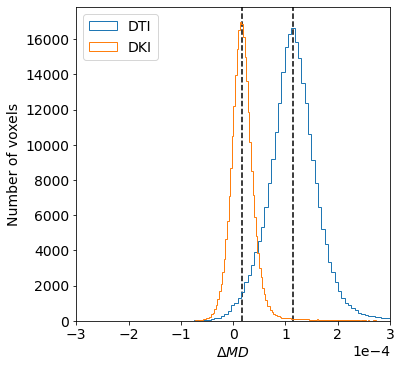

In [20]:
fig, ax = plt.subplots()
ax.hist(diff_dti, histtype='step', bins=200, label="DTI")
ax.hist(-diff_dki, histtype='step', bins=200, label="DKI")
ax.set_xlim([-0.0003, 0.0003])
ylims = ax.get_ylim()
ax.vlines(np.median(diff_dti), *ylims, color='k', linestyle='--')
ax.vlines(-np.median(diff_dki), *ylims, color='k', linestyle='--')
ax.set_ylim(ylims)
ax.set_xlabel("$\Delta MD$")
ax.set_ylabel("Number of voxels")
ax.set_box_aspect(1)
ax.ticklabel_format(axis="x", style='sci', scilimits=[0, 2])

plt.legend()
fig.set_size_inches([5.8, 5.8])
fig.set_tight_layout(True)
fig.savefig("single_subject_reliability_md.png")

In [15]:
mad_df = pd.DataFrame(data=dict(subjects=subjects, 
                                mad_dti=mad_dti, 
                                med_dti=med_dti, 
                                mad_dki=mad_dki,
                                med_dki=-np.array(med_dki)))


In [16]:
import seaborn as sns

In [17]:
#plt.plot(mad_dti, med_dti, '.')

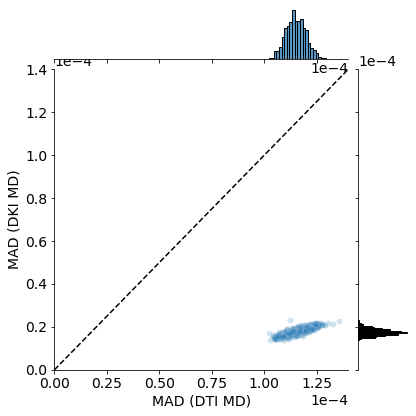

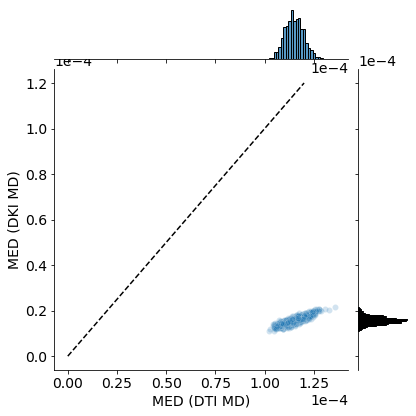

In [23]:
#fig, ax = plt.subplots(1,2)
pp = sns.jointplot(data=mad_df, x="mad_dti", y="mad_dki", alpha=0.2)
pp.ax_joint.set_xlabel("MAD (DTI MD)")
pp.ax_joint.set_ylabel("MAD (DKI MD)")
pp.ax_joint.set_xlim([0, 0.000140])
pp.ax_joint.set_ylim([0, 0.000140])
pp.ax_joint.plot([0, 0.000140], [0, 0.000140], 'k--')
#pp.ax_joint.text(0.1, 0.9, 'B', horizontalalignment='center',verticalalignment='center', transform=pp.ax_joint.transAxes, fontsize=20)
pp.ax_joint.ticklabel_format(style='sci', scilimits=[0, 2])
pp.fig.savefig("hcp_reliability_md_mad.svg")



pp = sns.jointplot(data=mad_df, x="med_dti", y="med_dki", alpha=0.2)
pp.ax_joint.set_xlabel("MED (DTI MD)")
pp.ax_joint.set_ylabel("MED (DKI MD)")
# pp.ax_joint.set_xlim([-0.01, 0.05])
# pp.ax_joint.set_ylim([-0.01, 0.05])
pp.ax_joint.plot([0, 0.00012], [0, 0.00012], 'k--')
# pp.ax_joint.hlines(0, 0, 0.00012, color='k', linestyle='--')
# pp.ax_joint.vlines(0, 0, 0.00012, color='k', linestyle='--')
#pp.ax_joint.text(0.1, 0.9, 'C', horizontalalignment='center',verticalalignment='center', transform=pp.ax_joint.transAxes, fontsize=20)
pp.ax_joint.ticklabel_format(style='sci', scilimits=[0, 2])
pp.fig.savefig("hcp_reliability_md_med.svg")

In [21]:
!open .